In [1]:
import qutip as qt
import matplotlib.pyplot as plt
from pycqed import *
from pycqed.util import *

## Local Basis Reduction Example

Reduction techniques are important to simplify the analysis of quantum annealing and computing systems. In general one wants to map the two lowest energy levels of the circuit Hamiltonian to a two-level system described by Pauli operators. Here we use [G. Consani's local basis reduction technique](https://arxiv.org/abs/1912.00464) which is superior to other methods with a wider range of validity and applicability.

### RF-SQUID Qubit

We will use the traditional RF-SQUID qubit as an example, which is setup as in the `csfq-example.ipynb` notebook:

In [2]:
graph = CircuitGraph()
graph.addBranch(0, 1, "C")
graph.addBranch(0, 1, "L")
graph.addBranch(0, 1, "I")
graph.drawGraphViz()
circuit = SymbolicSystem(graph)
hamil = NumericalSystem(circuit)
hamil.configureOperator(1, 50, "oscillator")

# Fabrication parameters
Ca = 60.0 # fF/um^2
Jc = 3.0  # uA/um^2
Aj = 0.2*1.2#0.4**2 # um^2

# Set the parameter values
hamil.setParameterValues(
    'C', Ca*Aj,
    'I', Jc*Aj,
    'L', 570.0,
    'phi10-2e', 0.5
)

Using existing PyCQED tmp output root directory '/tmp/.pycqed/'.


To use the local basis method we need to solve the eigenvalues and vectors at parameter value that we require the Pauli coefficients:

In [3]:
# Configure the diagonaliser
hamil.setDiagConfig(get_vectors=True)

The eigenvalues are used to generate the reduced Hamiltonian in the energy eigenbasis, and the eigenvectors are used to get the expectation value of the operator that defines the computational basis. With flux qubits a natural choice is the persistent current operator, which describes the average amplitude of the circulating current states in the loop. Therefore we need to get the relevant branch current operator during a sweep, which in general will depend on certain parameters.

Let's first get current operator associated with the JJ branch:

In [4]:
JJedge = graph.getComponentEdge('I')
JJedge

(1, 0, 2)

The current operator associated with the JJ depends on the external flux, and thus we need to obtain the operator at each flux point. We are interested in the ground state persistent current. We can get this information during a parameter sweep using the `current` evaluable, specifying the elements we wish to obtain using a set of matrix element indices:

In [5]:
hamil.addSweep('phi10-2e', 0.49, 0.51, 101)
hamil.addEvaluation('Hamiltonian')
hamil.addEvaluation('Current', edge=JJedge, elements=[(0, 0)])
sweep = hamil.paramSweep(timesweep=True)

Parameter Sweep Duration:
  Initialization:	0.028 s
  Loop duration:	1.153 s
  Avg iteration:	0.011 s


Get the Hamiltonian eigenvalues and vectors first:

In [6]:
x, EV, v = hamil.getSweep(sweep, 'phi10-2e', {}, evaluable='Hamiltonian')
E = EV[:,0]
V = EV[:,1]

Text(0, 0.5, '$E_{g,i}$ (GHz)')

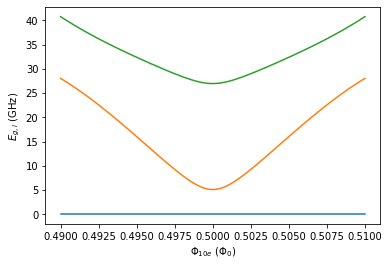

In [7]:
for i in range(3):
    plt.plot(x,E[i]-E[0])
plt.xlabel("$\\Phi_{10e}$ ($\\Phi_0$)")
plt.ylabel("$E_{g,i}$ (GHz)")

Now get the branch current:

In [8]:
x, I00, v = hamil.getSweep(sweep, 'phi10-2e', {}, evaluable='Current')

Note that we only asked for one matrix element and so the current array for that element is at index 0:

Text(0, 0.5, '$\\langle i| \\hat{I} |j \\rangle$ ($\\mu A$)')

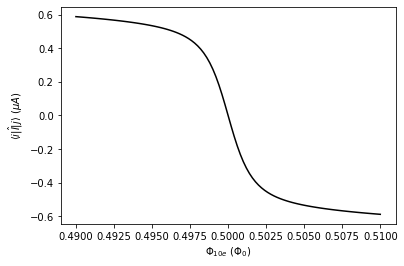

In [9]:
plt.plot(x, I00[0], "k-")
plt.xlabel("$\\Phi_{10e}$ ($\\Phi_0$)")
plt.ylabel("$\\langle i| \hat{I} |j \\rangle$ ($\mu A$)")

Because of our choice of basis here (charge), the flux operator is independent of `phi10e`, and thus there is no need to generate the operator at each value of flux bias. The Josephson current operator however does depend on `phi10e` so if it were used one would have to regenerate it for each flux bias value. In most cases it should suffice to get a branch current operator that is unique to a particular loop and is independent of the parameters being swept:

In [10]:
Ledge = graph.getComponentEdge('L')
Ledge

(0, 1, 1)

In [11]:
Op = hamil.getCurrentOperator(Ledge)
I00L = np.zeros(len(x))
for i in range(len(x)):
    I00L[i] = Op.matrix_element(V[0, i], V[0, i]).real

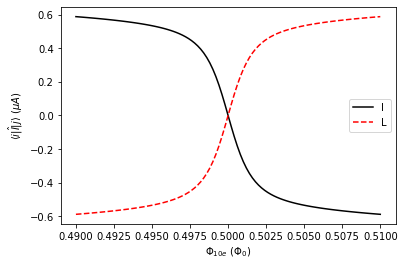

In [12]:
plt.plot(x, I00[0], "k-", label="I")
plt.plot(x, I00L, "r--", label="L")
plt.xlabel("$\\Phi_{10e}$ ($\\Phi_0$)")
plt.ylabel("$\\langle i| \hat{I} |j \\rangle$ ($\mu A$)")
plt.legend()

Now we are ready to get the Pauli coefficients for this circuit model:

In [13]:
hx, hy, hz = pauliCoefficients(E, V, Op)

Text(0, 0.5, 'Energy (GHz)')

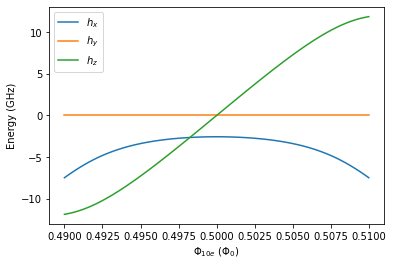

In [14]:
plt.plot(x,hx,label="$h_x$")
plt.plot(x,hy,label="$h_y$")
plt.plot(x,hz,label="$h_z$")
plt.legend()
plt.xlabel("$\\Phi_{10e}$ ($\\Phi_0$)")
plt.ylabel("Energy (GHz)")

We see that $h_y$ is zero and $h_x$ and $h_z$ behave as expected. We can verify the results by overlaying the energy spectrum generated by this two-level model to that of the original circuit:

In [15]:
# Check if spectrum matches original
Ered = np.array([0.0]*len(x))
for i in range(len(x)):
    H = hx[i]*qt.sigmax() + hy[i]*qt.sigmay() + hz[i]*qt.sigmaz()
    El = H.eigenenergies()
    Ered[i] = El[1]-El[0]

Text(0, 0.5, '$E_{g,i}$ (GHz)')

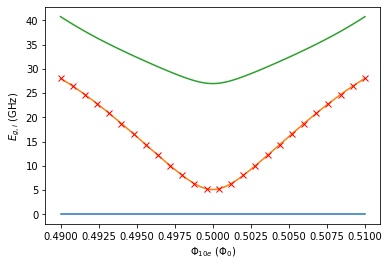

In [16]:
for i in range(3):
    plt.plot(x,E[i]-E[0])
plt.plot(x[::4],Ered[::4],"rx",label="Red.")
plt.xlabel("$\\Phi_{10e}$ ($\\Phi_0$)")
plt.ylabel("$E_{g,i}$ (GHz)")

Indeed the gap between the first two states matches almost exactly that of the original circuit:

Text(0, 0.5, 'Relative Error')

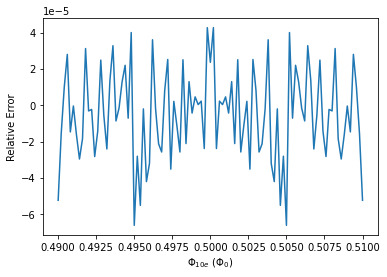

In [17]:
plt.plot(x,(E[1]-E[0])-Ered)
plt.xlabel("$\\Phi_{10e}$ ($\\Phi_0$)")
plt.ylabel("Relative Error")

### Cooper-Pair Box Qubit

Now we will perform the reduction on the cooper pair box, where now the computation basis is defined by the charge states.

In [18]:
graph = CircuitGraph()
graph.addBranch(0, 1, "C")
graph.addBranch(0, 1, "I")
graph.addChargeBias(1, "Cg1")
graph.drawGraphViz()
circuit = SymbolicSystem(graph)
hamil = NumericalSystem(circuit)
hamil.configureOperator(1, 20, "charge")

# Fabrication parameters
Ca = 60.0 # fF/um^2
Jc = 1.0  # uA/um^2
Aj = 0.1*0.1#0.4**2 # um^2

# Set the parameter values
hamil.setParameterValues(
    'C', Ca*Aj,
    'I', Jc*Aj,
    'Cg1', 1.0,
    'Q1e', 0.5
)

# Configure the diagonaliser
hamil.setDiagConfig(get_vectors=True)

Using existing PyCQED tmp output root directory '/tmp/.pycqed/'.


In this case the voltage operator is different at each value of applied gate voltage. It is then more convenient to construct a low energy subspace voltage operator out of the matrix elements corresponding to the lowest energy:

In [19]:
hamil.addSweep('Q1e', 0.4, 0.6, 101)
hamil.addEvaluation('Hamiltonian')
hamil.addEvaluation('Voltage', node=1, elements=[(0, 0), (0, 1), (1, 0), (1, 1)])
sweep = hamil.paramSweep(timesweep=True)

Parameter Sweep Duration:
  Initialization:	0.006 s
  Loop duration:	0.637 s
  Avg iteration:	0.006 s


In [20]:
x,EV,v = hamil.getSweep(sweep, 'Q1e', {}, evaluable='Hamiltonian')
E = EV[:,0]
V = EV[:,1]

Text(0, 0.5, '$E_{g,i}$ (GHz)')

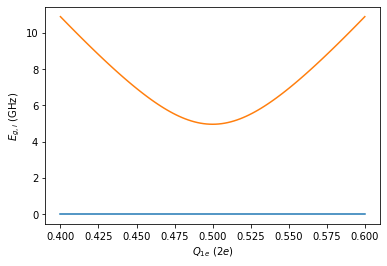

In [21]:
for i in range(2):
    plt.plot(x,E[i]-E[0])
plt.xlabel("$Q_{1e}$ ($2e$)")
plt.ylabel("$E_{g,i}$ (GHz)")

Now get the node voltage operator matrix elements:

In [22]:
x, Vii, v = hamil.getSweep(sweep, 'Q1e', {}, evaluable='Voltage')

Text(0, 0.5, '$\\langle i| \\hat{V} |j \\rangle$ ($\\mu V$)')

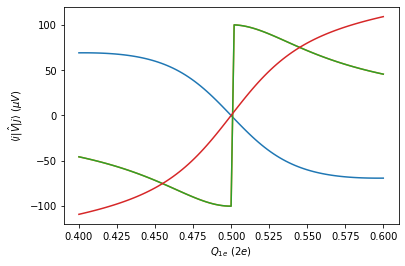

In [23]:
plt.plot(x, Vii[0])
plt.plot(x, Vii[1])
plt.plot(x, Vii[2])
plt.plot(x, Vii[3])
plt.xlabel("$Q_{1e}$ ($2e$)")
plt.ylabel("$\\langle i| \hat{V} |j \\rangle$ ($\mu V$)")

Construct the low energy subspace operators using the utility function:

In [24]:
ops = createSubspaceOperators(Vii[0], Vii[1], Vii[2], Vii[3])

In [25]:
hx,hy,hz = pauliCoefficients(E, V, ops)

Text(0, 0.5, 'Energy (GHz)')

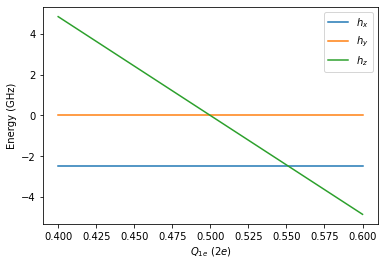

In [26]:
plt.plot(x,hx,label="$h_x$")
plt.plot(x,hy,label="$h_y$")
plt.plot(x,hz,label="$h_z$")
plt.legend()
plt.xlabel("$Q_{1e}$ ($2e$)")
plt.ylabel("Energy (GHz)")

In [27]:
# Check if spectrum matches original
Ered = np.array([0.0]*len(x))
for i in range(len(x)):
    H = hx[i]*qt.sigmax() + hy[i]*qt.sigmay() + hz[i]*qt.sigmaz()
    El = H.eigenenergies()
    Ered[i] = El[1]-El[0]

Text(0, 0.5, '$E_{g,i}$ (GHz)')

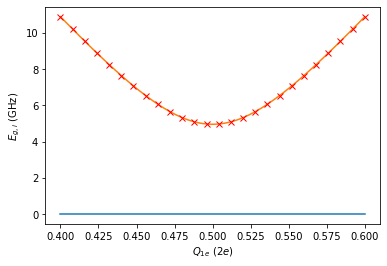

In [28]:
for i in range(2):
    plt.plot(x,E[i]-E[0])
plt.plot(x[::4],Ered[::4],"rx",label="Red.")
plt.xlabel("$Q_{1e}$ ($2e$)")
plt.ylabel("$E_{g,i}$ (GHz)")

Text(0, 0.5, 'Relative Error')

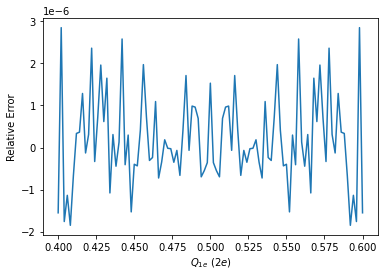

In [29]:
plt.plot(x,(E[1]-E[0])-Ered)
plt.xlabel("$Q_{1e}$ ($2e$)")
plt.ylabel("Relative Error")